# Task: Fine-tuning a language model to generate child-appropriate stories

Some notes:
* We will use DPO (Direct Preference Optimization), which is a simple RLHF fine-tuning method
* We will fine-tune a GPT2, is a small model with 124M  parameters


<a target="_blank" href="https://colab.research.google.com/github/MENA-ML/tutorials2025-tasks/blob/main/rlhf/dpo_Task.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [36]:
#@title Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, GPT2LMHeadModel, BertModel, BertTokenizer


from sklearn.cluster import KMeans
import numpy as np

import pickle
from google.colab import files

import pandas as pd

import matplotlib.pyplot as plt

from random import shuffle

In [37]:
#@title Parameters

max_story_length = 100
temp = 0.9
emb_model_name='bert-base-uncased'
model_name = 'gpt2'

FT_PATH = 'drive/MyDrive/model/gpt2/'

## Training modules

In [38]:
#@title Data modules

# Here we assume we have pairs {prompt, chosen_response, rejected_response}
class PreferenceDataset(Dataset):
    """
    A dataset of pairs (prompt, chosen_response, rejected_response).
    """
    def __init__(self, tokenizer, data, max_length=128):
        self.tokenizer = tokenizer
        self.data = data
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        prompt = sample['prompt']
        chosen = sample['chosen']
        rejected = sample['rejected']

        prompt_ids = self.tokenizer.encode(prompt, add_special_tokens=False)
        chosen_ids = self.tokenizer.encode(chosen, add_special_tokens=False)
        rejected_ids = self.tokenizer.encode(rejected, add_special_tokens=False)

        return {
            'prompt_ids': prompt_ids,
            'chosen_ids': chosen_ids,
            'rejected_ids': rejected_ids
        }

def collate_fn(batch, tokenizer, max_length=128):
    """
    Collate function that pads concatenated prompt+response sequences
    for chosen and rejected. Returns:
      - input_ids_chosen, attention_mask_chosen
      - input_ids_rejected, attention_mask_rejected
    """
    chosen_batch = []
    rejected_batch = []

    for sample in batch:
        # Concatenate prompt and response
        chosen_ids = sample['prompt_ids'] + sample['chosen_ids']
        rejected_ids = sample['prompt_ids'] + sample['rejected_ids']

        # Truncate to max_length if needed
        chosen_ids = chosen_ids[:max_length]
        rejected_ids = rejected_ids[:max_length]

        chosen_batch.append(chosen_ids)
        rejected_batch.append(rejected_ids)

    chosen_tensor = tokenizer.pad(
        {'input_ids': chosen_batch},
        padding=True,
        return_tensors='pt'
    )
    rejected_tensor = tokenizer.pad(
        {'input_ids': rejected_batch},
        padding=True,
        return_tensors='pt'
    )

    return (
        chosen_tensor['input_ids'],
        chosen_tensor['attention_mask'],
        rejected_tensor['input_ids'],
        rejected_tensor['attention_mask'],
    )


In [39]:
#@title TODO: DPO implementation

# Based on
# "Direct Preference Optimization: Your Language Model is
# Secretly a Reward Model" (Rafailov et al. 2024).

# TODO
def dpo_loss(
    chosen_logps,
    rejected_logps,
    alpha=1.0,
):
    chosen_logps = chosen_logps.sum(dim=-1)
    rejected_logps = rejected_logps.sum(dim=-1)

    #Compute reward difference (r_chosen - r_rejected)
    logits = alpha * (chosen_logps - rejected_logps)

    # Comput the loss using the sigmoid function
    loss = -torch.log(torch.sigmoid(logits)).mean()
    return(loss)
    """
    chosen_logps, rejected_logps: shape [batch_size, seq_len]
    alpha: hyperparameter controlling strength of likelihood ratio
    Formula:
       L = - E[ log( 1 / (1 + exp( - alpha (r_chosen - r_rejected) )) ) ]
    where r_* ~ alpha * log p_\theta(*)
    """

# TODO
def compute_logprobs(logits, input_ids):
    """
    Compute log probabilities of the model for each token in input_ids.
    logits: [batch_size, seq_len, vocab_size]
    input_ids: [batch_size, seq_len]
    returns: log_probs per token, shape [batch_size, seq_len]
    """
    log_probs = F.log_softmax(logits, dim=-1)
    log_probs = torch.gather(log_probs, dim=-1, index=input_ids.unsqueeze(-1)).squeeze(-1)
    return (log_probs)

# Bringing it all together in a training loop
def train_dpo(
    model,
    tokenizer,
    dataset,
    batch_size=2,
    alpha=1.0,
    lr=1e-5,
    num_epochs=2,
    max_length=128,
):
    """
    Training loop of DPO.
    """
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, tokenizer, max_length=max_length),
    )

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        for step, (chosen_ids, chosen_mask, rejected_ids, rejected_mask) in enumerate(data_loader):
            chosen_ids = chosen_ids.cuda() if torch.cuda.is_available() else chosen_ids
            chosen_mask = chosen_mask.cuda() if torch.cuda.is_available() else chosen_mask
            rejected_ids = rejected_ids.cuda() if torch.cuda.is_available() else rejected_ids
            rejected_mask = rejected_mask.cuda() if torch.cuda.is_available() else rejected_mask

            # Forward pass for chosen
            outputs_chosen = model(input_ids=chosen_ids, attention_mask=chosen_mask)
            # Forward pass for rejected
            outputs_rejected = model(input_ids=rejected_ids, attention_mask=rejected_mask)

            # Compute log probabilities per token
            chosen_logps = compute_logprobs(outputs_chosen.logits, chosen_ids)
            rejected_logps = compute_logprobs(outputs_rejected.logits, rejected_ids)

            # Compute DPO loss
            loss = dpo_loss(chosen_logps, rejected_logps, alpha=alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print(f'Epoch {epoch}, Step {step}')



## Show initial performance before fine-tuning

In [40]:
#@title Generate stories using GPT2 model

num_stories = 100

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have a pad_token, so use eos

model = GPT2LMHeadModel.from_pretrained(model_name)
if torch.cuda.is_available():
    model.cuda()

gpt2_stories = []
for i in range(num_stories):
  inputs = tokenizer('Here is a short story plot: ', return_tensors='pt')
  inputs.to(torch.device('cuda:0'))
  generation_output = model.generate(**inputs, do_sample=True, temperature=temp, max_length=max_story_length)
  out = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(generation_output[0]))
  gpt2_stories.append(out)
  #print(out)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [41]:
#@title Load GPT2-generated stories if we already have them...
# Load appropriate and inappropriate stories (from an external source)

"""
files.upload()

with open('gpt2_stories.pkl', 'rb') as file:
    gpt2_stories = pickle.load(file)

print('\n\n')

print('A sample story generated by GPT2: ')
print(gpt2_stories[10].replace('\xa0', ' '))
"""

"\nfiles.upload()\n\nwith open('gpt2_stories.pkl', 'rb') as file:\n    gpt2_stories = pickle.load(file)\n\nprint('\n\n')\n\nprint('A sample story generated by GPT2: ')\nprint(gpt2_stories[10].replace('\xa0', ' '))\n"

In [42]:
files.upload()
df = pd.read_csv('50_Childrens_Stories.csv')

files.upload()
df2 = pd.read_csv('50_Short_Stories.csv')

children_stories = []
for index, row in df.iterrows():
    children_stories.append(row['Story  '])

adult_stories = []
for index, row in df2.iterrows():
    adult_stories.append(row['Content'])

print('\n\n')

print('Sample children story: ')
print(children_stories[0])

print('\n\n')

print('Sample story with adult content: ')
print(adult_stories[20])


Saving 50_Childrens_Stories.csv to 50_Childrens_Stories (2).csv


Saving 50_Short_Stories.csv to 50_Short_Stories (2).csv



Sample children story: 
Ella found a crayon in her backyard. When she drew a flower, it bloomed in real life! She drew a tree, and it grew tall and strong. Excited, she drew a castle, but it was too big for her yard. The crayon whispered, 'Use me wisely.' Ella smiled and drew a playground for all the kids in her neighborhood.  



Sample story with adult content: 
After her husband’s death, Mary found a note in his desk. “If anything happens to me, it wasn’t an accident,” it read. She showed it to the police, but they dismissed it. That night, she heard footsteps in her house.


In [43]:
#@title Cluster BERT embeddings of stories

def get_embeddings(stories, tokenizer, model):

  all_embeddings = []

  for story in stories:

    input_ids = tokenizer.encode(story[:max_story_length], add_special_tokens=True)
    input_ids = torch.tensor([input_ids])

    with torch.no_grad():
      last_hidden_states = model(input_ids)[0] # Models outputs are now tuples
    last_hidden_states = last_hidden_states.mean(1)

    all_embeddings.append(last_hidden_states)

  X = np.array([t.detach().cpu().numpy() for t in all_embeddings]).squeeze()

  return X


emb_tokenizer = BertTokenizer.from_pretrained(emb_model_name)
emb_model = BertModel.from_pretrained(emb_model_name)

all_stories = children_stories + adult_stories + gpt2_stories
num_children_stories = len(children_stories)
num_adult_stories = len(adult_stories)
num_gpt2_stories = len(gpt2_stories)
num_stories = len(all_stories)

X = get_embeddings(all_stories, emb_tokenizer, emb_model)

X_comp = X[:num_children_stories+num_adult_stories,:]
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto').fit(X_comp)
centers = np.array(kmeans.cluster_centers_)

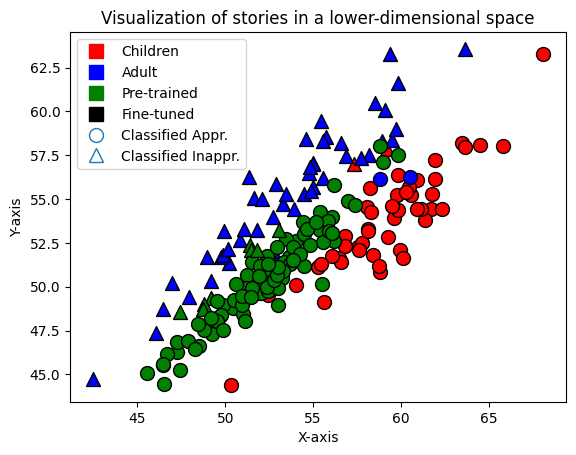

In [44]:
#@title Visualize GPT2-generated stories (before fine-tuning)

# Create a scatter plot
def myPlot(x, colors, markers):

  for i in range(x.shape[0]):
    plt.scatter(
        x[i,0], x[i,1],
        c=colors[i],
        marker=markers[i],
        edgecolor='k',
        s=100
    )

  legend = [
      plt.Line2D([0], [0], color='red', marker='s', linestyle='',
                 markersize=10, label='Children'),
      plt.Line2D([0], [0], color='blue', marker='s', linestyle='',
                 markersize=10, label='Adult'),
      plt.Line2D([0], [0], color='green', marker='s', linestyle='',
                 markersize=10, label='Pre-trained'),
      plt.Line2D([0], [0], color='black', marker='s', linestyle='',
                 markersize=10, label='Fine-tuned'),
      plt.Line2D([0], [0], marker='o', linestyle='',
                 markersize=10, label='Classified Appr.', fillstyle='none'),
      plt.Line2D([0], [0], marker='^', linestyle='',
                 markersize=10, label='Classified Inappr.', fillstyle='none')
  ]
  plt.legend(handles=legend)

  plt.xlabel('X-axis')
  plt.ylabel('Y-axis')
  plt.title('Visualization of stories in a lower-dimensional space')
  plt.show()


# find labels for the gpt2-generated stories
X_gpt2 = X[-num_gpt2_stories:,:]
Y = X_gpt2 @ centers.transpose()
gpt2_labels = (Y[:,0] < Y[:,1]).astype(int)
all_labels = np.concatenate([kmeans.labels_, gpt2_labels], axis=0)
#print(all_labels)

colors = [0]*num_stories
for i in range(num_stories):
  if i < num_children_stories:
    colors[i] = 'red'
  elif i < num_children_stories+num_adult_stories:
    colors[i] = 'blue'
  else:
    colors[i] = 'green'

markers = ['o' if label == 0 else '^' for label in all_labels]

x = X @ centers.transpose()

myPlot(x, colors, markers)

## Run DPO

In [45]:
#@title Create a comparison dataset for RLHF

comparison_data = []
for chosen in children_stories:
  for rejected in adult_stories:
    comparison = {
        'prompt': 'Here is a short story plot: ',
        'chosen': chosen,
        'rejected': rejected
    }
    comparison_data.append(comparison)

shuffle(comparison_data)

In [46]:
comparison_data[0]

{'prompt': 'Here is a short story plot: ',
 'chosen': 'Lila found shoes that made her dance perfectly. She danced in competitions and won trophies. But one day, the shoes stopped working. Lila realized she didn’t need them—she had learned to dance on her own.  ',
 'rejected': 'The hotel room was cheap, and the reviews warned of strange noises. She didn’t believe in ghosts, so she booked it anyway. That night, she heard knocking from inside the closet. When she opened it, there was nothing there—just a faint smell of perfume. The next morning, she found scratches on the inside of the closet door.'}

In [47]:
#@title Run DPO


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't have a pad_token, so use eos

dataset = PreferenceDataset(tokenizer, comparison_data)

print('Loading the model...')

# Initialize model
model = GPT2LMHeadModel.from_pretrained(model_name).train()
if torch.cuda.is_available():
    model.cuda()

# Train for demonstration (will quickly overfit given small dataset)
print('Starting DPO Training...')
train_dpo(
    model,
    tokenizer,
    dataset,
    batch_size=1,
    alpha=1.0,
    lr=1e-5,
    num_epochs=5,
    max_length=64,
)
print('DPO Training Complete.')

Loading the model...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Starting DPO Training...
Epoch 0, Step 0
Epoch 0, Step 100
Epoch 0, Step 200
Epoch 0, Step 300
Epoch 0, Step 400
Epoch 0, Step 500
Epoch 0, Step 600
Epoch 0, Step 700
Epoch 0, Step 800
Epoch 0, Step 900
Epoch 0, Step 1000
Epoch 0, Step 1100
Epoch 0, Step 1200
Epoch 0, Step 1300
Epoch 0, Step 1400
Epoch 0, Step 1500
Epoch 0, Step 1600
Epoch 0, Step 1700
Epoch 0, Step 1800
Epoch 0, Step 1900
Epoch 0, Step 2000
Epoch 0, Step 2100
Epoch 0, Step 2200
Epoch 0, Step 2300
Epoch 0, Step 2400
Epoch 1, Step 0
Epoch 1, Step 100
Epoch 1, Step 200
Epoch 1, Step 300
Epoch 1, Step 400
Epoch 1, Step 500
Epoch 1, Step 600
Epoch 1, Step 700
Epoch 1, Step 800
Epoch 1, Step 900
Epoch 1, Step 1000
Epoch 1, Step 1100
Epoch 1, Step 1200
Epoch 1, Step 1300
Epoch 1, Step 1400
Epoch 1, Step 1500
Epoch 1, Step 1600
Epoch 1, Step 1700
Epoch 1, Step 1800
Epoch 1, Step 1900
Epoch 1, Step 2000
Epoch 1, Step 2100
Epoch 1, Step 2200
Epoch 1, Step 2300
Epoch 1, Step 2400
Epoch 2, Step 0
Epoch 2, Step 100
Epoch 2, Step 2

In [70]:
#@title Load a fine-tuned model

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token


model = GPT2LMHeadModel.from_pretrained("gpt2", local_files_only=True)

# if torch.cuda.is_available():
#     model.cuda()


In [74]:
# Performance after fine-tuning
# Generate some stories and see if they are appropriate
import os
import torch

# Ensure CUDA errors are reported synchronously for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check for CUDA availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print detailed CUDA information
if torch.cuda.is_available():
    print(f"Current Device: {torch.cuda.current_device()}")
    print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available, using CPU instead.")

# Move the model to the correct device
model.to('cpu')  # Move model to CPU first
inputs = {k: v.to('cpu') for k, v in inputs.items()}  # Move inputs to CPU
# model.to('cuda')  # Then move model back to CUDA after debugging
# inputs = {k: v.to('cuda') for k, v in inputs.items()}  # Move inputs to CUDA


# Tokenize the input text
inputs = tokenizer('Here is a short story plot: ', return_tensors='pt')
print(inputs['input_ids'])  # Check the token IDs

# Debugging: Print tensor details before moving to the device
print("Before moving to device:")
for k, v in inputs.items():
    print(f"Key: {k}, Shape: {v.shape}, Device: {v.device}, Dtype: {v.dtype}")

# Debugging: Print tensor details after moving to the device
print("After moving to device:")
for k, v in inputs.items():
    print(f"Key: {k}, Shape: {v.shape}, Device: {v.device}, Dtype: {v.dtype}")

# Now the model is ready to make predictions
outputs = model(**inputs)

new_stories = []
for i in range(100):
  #print("\n\n\n"+str(i)+" :\n")
  generation_output = model.generate(**inputs, do_sample=True, temperature=0.9, max_length=max_story_length)
  out = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(generation_output[0]))
  new_stories.append(out)
  #print(out)

Using device: cuda
Current Device: 0
Device Name: Tesla T4
tensor([[4342,  318,  257, 1790, 1621, 7110,   25,  220]])
Before moving to device:
Key: input_ids, Shape: torch.Size([1, 8]), Device: cpu, Dtype: torch.int64
Key: attention_mask, Shape: torch.Size([1, 8]), Device: cpu, Dtype: torch.int64
After moving to device:
Key: input_ids, Shape: torch.Size([1, 8]), Device: cpu, Dtype: torch.int64
Key: attention_mask, Shape: torch.Size([1, 8]), Device: cpu, Dtype: torch.int64


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

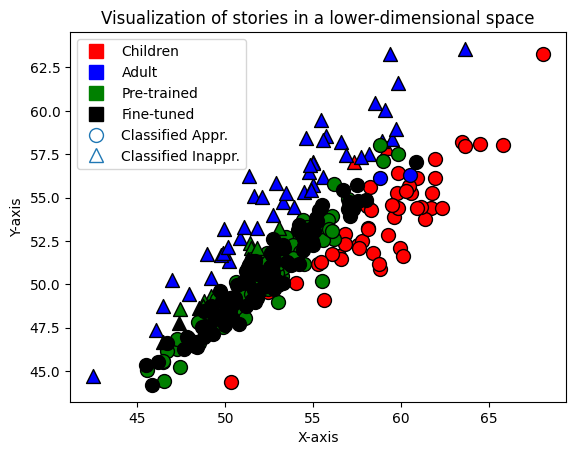

In [75]:
#@title Visualize new stories

# find labels for the gpt2-generated stories
X_new = get_embeddings(new_stories, emb_tokenizer, emb_model)
X = np.concatenate([X, X_new], axis=0)

Y_new = X_new @ centers.transpose()
labels_new = (Y_new[:,0] < Y_new[:,1]).astype(int)
all_labels = np.concatenate([all_labels, labels_new], axis=0)

colors = colors + ['black']*len(new_stories)

markers = ['o' if label == 0 else '^' for label in all_labels]

x = X @ centers.transpose()

myPlot(x, colors, markers)